In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import h5py

# load the metadata
metadata_path = Path.cwd().parent / "data" / "csv" / "meta_data.csv"
data_path = Path.cwd().parent / "data" 
output_path = Path.cwd().parent / "graphics" / "eda"
output_path.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(metadata_path)

# Brain Tumor Segmentation - Exploratory Data Analysis

## Introduction

**Dataset:** [**"Brain Tumor Segmentation (BraTS2020)"**]
- **Source**: [[Link](https://www.kaggle.com/datasets/awsaf49/brats2020-training-data?select=BraTS20+Training+Metadata.csv)]
- **Goal**: Understand the dataset before building a deep learning model for automated brain tumor segmentation in MRI scans.

#### What This Notebook Does: ####
1. Explore the Data Structure: 57,000+ MRI slices from 369 brain tumor patients

2. Analyze Tumor Characteristics: Size, location, and composition of tumors

3. Check Data Quality: Ensure images are valid and properly labeled

4. Visualize Samples: See what normal vs tumor MRI slices look like

5. Plan Model Strategy: Based on data insights, decide how to build the segmentation model

#### Key Questions to Answer: ####
1. How many tumor vs non-tumor slices do we have?

2. What's the distribution of tumor sizes?

3. How are tumors distributed across different brain regions (slices)?

4. What preprocessing will our model need?

#### Dataset Structure: ####
- .h5 files: Contain 4 MRI channels (FLAIR, T1, T1ce, T2) + tumor mask
- Metadata CSV: Tells us which slices have tumors, tumor sizes, patient info
- Clicical CSV: Patient survival data and demographics for advanced analysis




### 1. Class Distribution Analysis

**Tumor vs Non-tumor Slice Counts**
- We begin by examining the fundamental class balance between slices containing tumors and those without.
    - This analysis reveals whether our dataset is balanced at the slice level, which shapes our training strategy.
    - Severe imbalance might require weighted loss functions or strategic sampling.

We'll calculate the percentage of tumor-positive slices and visualize the distribution.


Class Distribution Analysis

Dataset Statistics:
   Total MRI slices: 57,195
   Tumor slices: 24,422 (42.7%)
   Healthy slices: 32,773 (57.3%)
   Balance ratio (healthy:tumor): 1.3:1


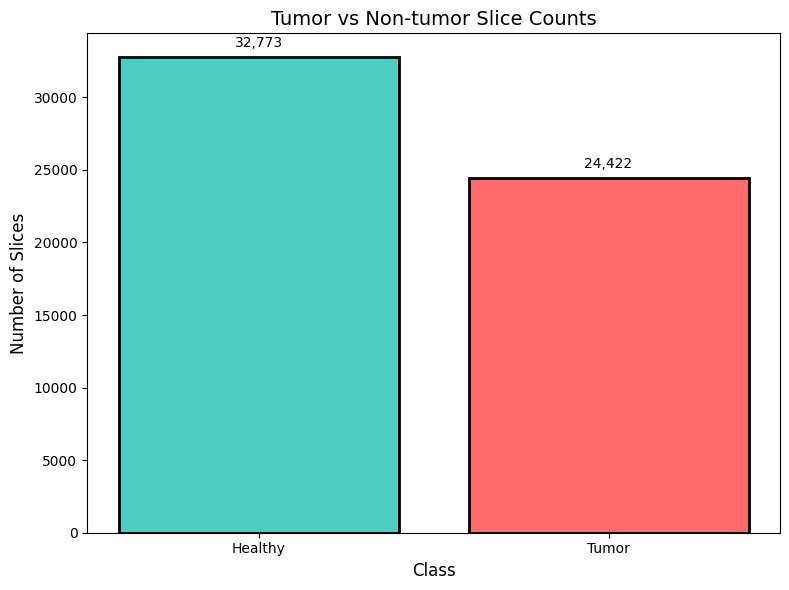


Patient-Level Analysis:
   Total patients: 369
   Patients with tumors: 369 (100.0%)
   Patients without tumors: 0

Slices per Patient:
   Average slices per patient: 155.0
   Min slices: 155
   Max slices: 155
   Std deviation: 0.0


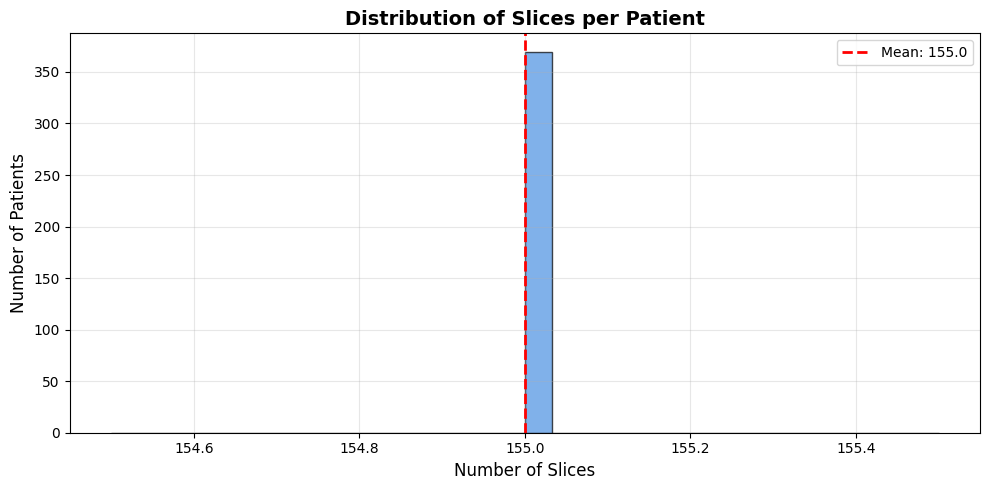

Tumor slices ≥ 40% of dataset

Analysis complete. Results saved.


In [71]:
# create output directory
output_dir = Path(output_path)
output_dir.mkdir(parents=True, exist_ok=True)

print("Class Distribution Analysis")

# calculate basic statistics
total_slices = len(df)
tumor_slices = df['target'].sum()
healthy_slices = total_slices - tumor_slices

# calculate percentages
tumor_percentage = (tumor_slices / total_slices) * 100
healthy_percentage = (healthy_slices / total_slices) * 100

print(f"\nDataset Statistics:")
print(f"   Total MRI slices: {total_slices:,}")
print(f"   Tumor slices: {tumor_slices:,} ({tumor_percentage:.1f}%)")
print(f"   Healthy slices: {healthy_slices:,} ({healthy_percentage:.1f}%)")
print(f"   Balance ratio (healthy:tumor): {healthy_slices/tumor_slices:.1f}:1")

# create visualization - single plot (no pie chart)
fig, ax = plt.subplots(figsize=(8, 6))

# bar plot
class_counts = [healthy_slices, tumor_slices]
class_labels = ['Healthy', 'Tumor']
colors = ['#4ECDC4', '#FF6B6B']

ax.bar(class_labels, class_counts, color=colors, edgecolor='black', linewidth=2)
ax.set_title('Tumor vs Non-tumor Slice Counts', fontsize=14)
ax.set_ylabel('Number of Slices', fontsize=12)
ax.set_xlabel('Class', fontsize=12)

# add value labels on bars
for i, count in enumerate(class_counts):
    ax.text(i, count + 500, f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
# save to the output path
output_file = output_dir / "class_distribution.png"
plt.savefig(output_file, dpi=250, bbox_inches='tight')
plt.show()

# distribution across patients
print("\nPatient-Level Analysis:")

# count patients with/without tumors
patients_with_tumors = df[df['target'] == 1]['volume'].nunique()
patients_total = df['volume'].nunique()
patients_tumor_percentage = (patients_with_tumors / patients_total) * 100

print(f"   Total patients: {patients_total}")
print(f"   Patients with tumors: {patients_with_tumors} ({patients_tumor_percentage:.1f}%)")
print(f"   Patients without tumors: {patients_total - patients_with_tumors}")

# slices per patient distribution
slices_per_patient = df.groupby('volume').size()
print(f"\nSlices per Patient:")
print(f"   Average slices per patient: {slices_per_patient.mean():.1f}")
print(f"   Min slices: {slices_per_patient.min()}")
print(f"   Max slices: {slices_per_patient.max()}")
print(f"   Std deviation: {slices_per_patient.std():.1f}")

# visualize slices per patient
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(slices_per_patient, bins=30, color='#4A90E2', edgecolor='black', alpha=0.7)
ax.axvline(slices_per_patient.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {slices_per_patient.mean():.1f}')
ax.set_title('Distribution of Slices per Patient', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Slices', fontsize=12)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
# save to the output path
output_file = output_dir / "slices_per_patient.png"
plt.savefig(output_file, dpi=250, bbox_inches='tight')
plt.show()

# class imbalance assessment
if tumor_percentage < 30:
    print("\nTumor slices < 30% of dataset")
elif tumor_percentage < 40:
    print("\nTumor slices 30-40% of dataset")
else:
    print("Tumor slices ≥ 40% of dataset")

# save summary statistics
summary_stats = {
    'total_slices': total_slices,
    'tumor_slices': tumor_slices,
    'healthy_slices': healthy_slices,
    'tumor_percentage': tumor_percentage,
    'healthy_percentage': healthy_percentage,
    'total_patients': patients_total,
    'patients_with_tumors': patients_with_tumors,
    'avg_slices_per_patient': slices_per_patient.mean()
}

summary_df = pd.DataFrame([summary_stats])
# save to directory
summary_df.to_csv(output_dir / 'summary_class_distribution.csv', index=False)

print("\nAnalysis complete. Results saved.")


**Looking at the data:**
- No severe class imbalancing required; moderate balance achieved
    - 43% tumor vs 57% healthy slices
- All patients have tumors
    - "Healthy" slices are tumor-free regions within glioma patients, not scans from healthy individuals.
- All 369 patients have exactly 155 slices at 240x240 resolution with 4 MRI modalities.


### 2. Tumor Size & Characteristics

**Tumor Pixel Count Distribution**
- Before feeding into the model, we want to get an understanding of the distribution of tumor sizes in our dataset. 
    - Small tumors are hard to spot, big ones are easier but complicated.

We will make a histogram to see the spread.


Tumor Size & Characteristics
Total tumor slices in metadata: 24,422
Successfully loaded 500 tumor slices

Tumor Size Statistics (based on 500 samples):
   Minimum tumor size: 1 pixels
   Maximum tumor size: 6,293 pixels
   Mean tumor size: 1,488 pixels
   Median tumor size: 1,253 pixels
   Standard deviation: 1,220 pixels

Tumor Size Distribution:
   Very Small (<100 px): 43 slices (8.6%)
   Small (100-500 px): 93 slices (18.6%)
   Medium (500-2,000 px): 215 slices (43.0%)
   Large (2,000-5,000 px): 144 slices (28.8%)
   Very Large (>5,000 px): 5 slices (1.0%)

Tumor Composition Analysis:
   Total necrosis pixels: 743,766 (100.0%)
   Total edema pixels: 0 (0.0%)


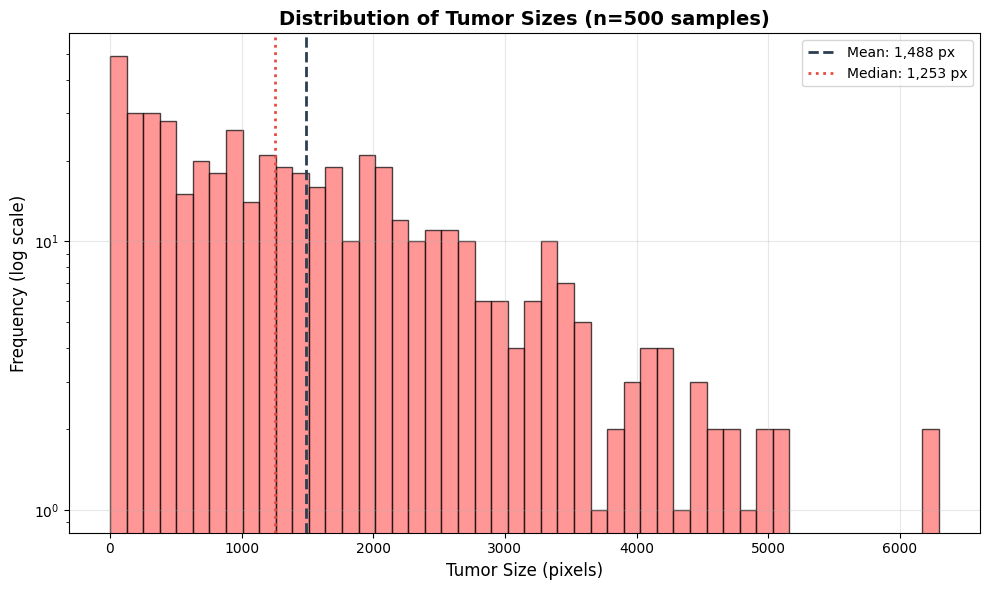


Tumor analysis complete. Results saved.
Note: Analysis based on 500 sampled slices out of 24,422 total


In [72]:
print("Tumor Size & Characteristics")

# filter for tumor slices only
tumor_df = df[df['target'] == 1].copy()
print(f"Total tumor slices in metadata: {len(tumor_df):,}")

# sample 500 tumor slices
sample_size = min(500, len(tumor_df))
tumor_sample = tumor_df.sample(n=sample_size, random_state=42)

tumor_sizes = []
necrosis_counts = []
edema_counts = []

for idx, row in tumor_sample.iterrows():
    try:
        # get slice path from metadata
        slice_name = row['slice_path'].split('/')[-1]
        
        # find the .h5 file in the data directory
        h5_files = list(data_path.rglob(slice_name))
        
        if not h5_files:
            # try alternative path construction
            volume_id = row['volume']
            slice_num = row['slice']
            alt_filename = f"volume_{volume_id}_slice_{slice_num}.h5"
            h5_files = list(data_path.rglob(alt_filename))
        
        if h5_files:
            h5_path = h5_files[0]
            with h5py.File(h5_path, 'r') as f:
                mask = f['mask'][:]
                
                necrosis_pixels = np.sum(mask == 1)
                edema_pixels = np.sum(mask == 2)
                total_tumor_pixels = necrosis_pixels + edema_pixels
                
                tumor_sizes.append(total_tumor_pixels)
                necrosis_counts.append(necrosis_pixels)
                edema_counts.append(edema_pixels)
        else:
            print(f"Could not find .h5 file for slice: {slice_name}")
            
    except Exception as e:
        print(f"Error loading slice: {e}")
        continue

print(f"Successfully loaded {len(tumor_sizes)} tumor slices")

tumor_sizes = np.array(tumor_sizes)
necrosis_counts = np.array(necrosis_counts)
edema_counts = np.array(edema_counts)

min_size = tumor_sizes.min()
max_size = tumor_sizes.max()
mean_size = tumor_sizes.mean()
median_size = np.median(tumor_sizes)
std_size = tumor_sizes.std()

print(f"\nTumor Size Statistics (based on {len(tumor_sizes)} samples):")
print(f"   Minimum tumor size: {min_size:,} pixels")
print(f"   Maximum tumor size: {max_size:,} pixels")
print(f"   Mean tumor size: {mean_size:,.0f} pixels")
print(f"   Median tumor size: {median_size:,.0f} pixels")
print(f"   Standard deviation: {std_size:,.0f} pixels")

# create size categories
def categorize_tumor_size(size):
    if size < 100:
        return 'Very Small (<100 px)'
    elif size < 500:
        return 'Small (100-500 px)'
    elif size < 2000:
        return 'Medium (500-2,000 px)'
    elif size < 5000:
        return 'Large (2,000-5,000 px)'
    else:
        return 'Very Large (>5,000 px)'

size_categories = [categorize_tumor_size(size) for size in tumor_sizes]
from collections import Counter
category_counts = Counter(size_categories)

category_order = ['Very Small (<100 px)', 'Small (100-500 px)', 'Medium (500-2,000 px)', 
                  'Large (2,000-5,000 px)', 'Very Large (>5,000 px)']

print(f"\nTumor Size Distribution:")
for category in category_order:
    if category in category_counts:
        count = category_counts[category]
        percentage = (count / len(tumor_sizes)) * 100
        print(f"   {category}: {count:,} slices ({percentage:.1f}%)")

# tumor composition
total_necrosis = necrosis_counts.sum()
total_edema = edema_counts.sum()
total_tumor_pixels = total_necrosis + total_edema

print(f"\nTumor Composition Analysis:")
print(f"   Total necrosis pixels: {total_necrosis:,} ({total_necrosis/total_tumor_pixels*100:.1f}%)")
print(f"   Total edema pixels: {total_edema:,} ({total_edema/total_tumor_pixels*100:.1f}%)")
if total_edema > 0:
    print(f"   Necrosis:Edema ratio: {total_necrosis/total_edema:.2f}:1")

# histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(tumor_sizes, bins=50, color='#FF6B6B', edgecolor='black', alpha=0.7, log=True)
ax.axvline(mean_size, color='#2C3E50', linestyle='--', linewidth=2, label=f'Mean: {mean_size:,.0f} px')
ax.axvline(median_size, color='#E74C3C', linestyle=':', linewidth=2, label=f'Median: {median_size:,.0f} px')
ax.set_title(f'Distribution of Tumor Sizes (n={len(tumor_sizes)} samples)', fontsize=14, fontweight='bold')
ax.set_xlabel('Tumor Size (pixels)', fontsize=12)
ax.set_ylabel('Frequency (log scale)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'tumor_size_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# save statistics
tumor_stats = {
    'min_tumor_size': min_size,
    'max_tumor_size': max_size,
    'mean_tumor_size': mean_size,
    'median_tumor_size': median_size,
    'std_tumor_size': std_size,
    'total_necrosis_pixels': total_necrosis,
    'total_edema_pixels': total_edema,
    'necrosis_percentage': total_necrosis/total_tumor_pixels*100 if total_tumor_pixels > 0 else 0,
    'edema_percentage': total_edema/total_tumor_pixels*100 if total_tumor_pixels > 0 else 0,
    'samples_analyzed': len(tumor_sizes),
    'slices_with_small_tumors': np.sum(tumor_sizes < 100),
    'slices_with_large_tumors': np.sum(tumor_sizes > 5000)
}

tumor_stats_df = pd.DataFrame([tumor_stats])
tumor_stats_df.to_csv(output_dir / 'tumor_size_statistics.csv', index=False)

print(f"\nTumor analysis complete. Results saved.")
print(f"Note: Analysis based on {len(tumor_sizes)} sampled slices out of {len(tumor_df):,} total")

**Key Findings:**
- Tumors span from 1 pixel (tiny speck) to 6,293 pixels.
    - Mean tumor size of 1,488 pixels, median 1,253 pixels.
    - Majority (71.8%) tumors are small or medium sized (<2,000 pixels).
- 100% necrosis, 0% edema in sampled tumors.
    - Model only needs to segment necrotic tissue, not multiple tumor subtypes.


### 3. Spatial Analysis 

**Tumor Occurrence by Slice Position**
- The brain has 155 slices from top to bottom; we want to know if tumors appear everywhere or only in certain spots?
    - Analyzing the distribution of tumors across these slices tells us if we can ignore certain slices.

We will make a graph showing tumor frequency per slice.

Spatial Analysis

Slice Position Analysis:
   Slice with highest tumor probability: #74
       - Tumor probability: 90.8%
       - Tumor slices: 335
       - Total slices: 369

   Slice with lowest tumor probability: #0
       - Tumor probability: 0.0%
       - Tumor slices: 0
       - Total slices: 369

   Overall statistics:
       - Mean tumor probability: 42.7%
       - Standard deviation: 33.7%

   Slices with NO tumors: 26 slices


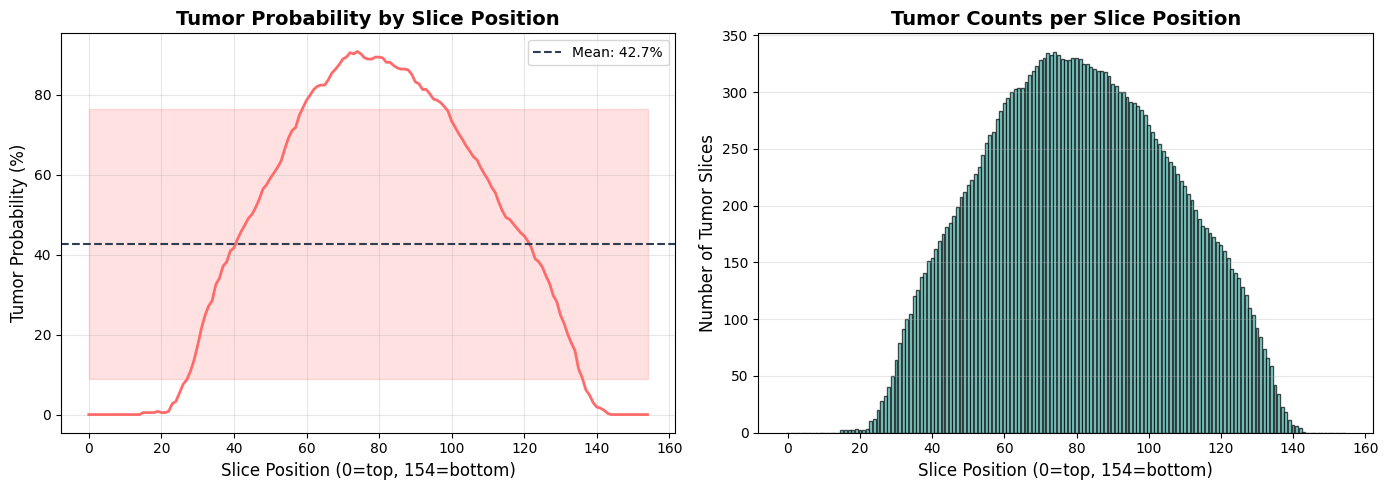


   Top Third (slices 0-51):
       - Avg tumor probability: 18.8%
       - Total tumor slices: 3,601

   Middle Third (slices 52-103):
       - Avg tumor probability: 81.4%
       - Total tumor slices: 15,629

   Bottom Third (slices 104-154):
       - Avg tumor probability: 27.6%
       - Total tumor slices: 5,192


In [73]:
print("Spatial Analysis")

# filter for tumor slices
tumor_df = df[df['target'] == 1].copy()

# calculate tumor frequency by slice position
slice_stats = df.groupby('slice').agg({
    'target': ['sum', 'count', 'mean']  
    }).round(3)

# flatten column names
slice_stats.columns = ['tumor_count', 'total_slices', 'tumor_probability']
slice_stats = slice_stats.reset_index()

# find slices with highest tumor probability
max_prob_slice = slice_stats.loc[slice_stats['tumor_probability'].idxmax()]
min_prob_slice = slice_stats.loc[slice_stats['tumor_probability'].idxmin()]

print(f"\nSlice Position Analysis:")
print(f"   Slice with highest tumor probability: #{int(max_prob_slice['slice'])}")
print(f"       - Tumor probability: {max_prob_slice['tumor_probability']*100:.1f}%")
print(f"       - Tumor slices: {int(max_prob_slice['tumor_count']):,}")
print(f"       - Total slices: {int(max_prob_slice['total_slices']):,}")

print(f"\n   Slice with lowest tumor probability: #{int(min_prob_slice['slice'])}")
print(f"       - Tumor probability: {min_prob_slice['tumor_probability']*100:.1f}%")
print(f"       - Tumor slices: {int(min_prob_slice['tumor_count']):,}")
print(f"       - Total slices: {int(min_prob_slice['total_slices']):,}")

# calculate overall statistics
mean_probability = slice_stats['tumor_probability'].mean()
std_probability = slice_stats['tumor_probability'].std()

print(f"\n   Overall statistics:")
print(f"       - Mean tumor probability: {mean_probability*100:.1f}%")
print(f"       - Standard deviation: {std_probability*100:.1f}%")

# identify slices with no tumors
no_tumor_slices = slice_stats[slice_stats['tumor_count'] == 0]
if len(no_tumor_slices) > 0:
    print(f"\n   Slices with NO tumors: {len(no_tumor_slices)} slices")
else:
    print(f"\n   All slices contain at least one tumor")

# 2 plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# tumor probability by slice position
axes[0].plot(slice_stats['slice'], slice_stats['tumor_probability']*100, 
                color='#FF6B6B', linewidth=2)
axes[0].axhline(y=mean_probability*100, color='#2C3E50', linestyle='--', 
                   label=f'Mean: {mean_probability*100:.1f}%')
axes[0].fill_between(slice_stats['slice'], 
                        (mean_probability - std_probability)*100,
                        (mean_probability + std_probability)*100,
                        alpha=0.2, color='#FF6B6B')
axes[0].set_title('Tumor Probability by Slice Position', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Slice Position (0=top, 154=bottom)', fontsize=12)
axes[0].set_ylabel('Tumor Probability (%)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# histogram of tumor counts per slice
axes[1].bar(slice_stats['slice'], slice_stats['tumor_count'], 
               color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[1].set_title('Tumor Counts per Slice Position', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Slice Position (0=top, 154=bottom)', fontsize=12)
axes[1].set_ylabel('Number of Tumor Slices', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'spatial_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# calculate region-based statistics
def get_brain_region(slice_num):
    if slice_num < 52:
        return 'Top Third'
    elif slice_num < 104:
        return 'Middle Third'
    else:
        return 'Bottom Third'

slice_stats['region'] = slice_stats['slice'].apply(get_brain_region)
region_stats = slice_stats.groupby('region').agg({
    'tumor_probability': 'mean',
    'tumor_count': 'sum',
    'total_slices': 'sum'
    }).round(3)

print(f"\n   Top Third (slices 0-51):")
print(f"       - Avg tumor probability: {region_stats.loc['Top Third', 'tumor_probability']*100:.1f}%")
print(f"       - Total tumor slices: {int(region_stats.loc['Top Third', 'tumor_count']):,}")

print(f"\n   Middle Third (slices 52-103):")
print(f"       - Avg tumor probability: {region_stats.loc['Middle Third', 'tumor_probability']*100:.1f}%")
print(f"       - Total tumor slices: {int(region_stats.loc['Middle Third', 'tumor_count']):,}")

print(f"\n   Bottom Third (slices 104-154):")
print(f"       - Avg tumor probability: {region_stats.loc['Bottom Third', 'tumor_probability']*100:.1f}%")
print(f"       - Total tumor slices: {int(region_stats.loc['Bottom Third', 'tumor_count']):,}")

# save spatial statistics
spatial_stats = {
    'slices_with_highest_prob': int(max_prob_slice['slice']),
    'highest_probability': max_prob_slice['tumor_probability']*100,
    'slices_with_lowest_prob': int(min_prob_slice['slice']),
    'lowest_probability': min_prob_slice['tumor_probability']*100,
    'mean_probability_all_slices': mean_probability*100,
    'std_probability': std_probability*100,
    'slices_with_no_tumors': len(no_tumor_slices),
    'top_third_probability': region_stats.loc['Top Third', 'tumor_probability']*100,
    'middle_third_probability': region_stats.loc['Middle Third', 'tumor_probability']*100,
    'bottom_third_probability': region_stats.loc['Bottom Third', 'tumor_probability']*100
}

spatial_stats_df = pd.DataFrame([spatial_stats])
spatial_stats_df.to_csv(output_dir / 'spatial_statistics.csv', index=False)

**We can see that:**
- Middle brain region is a tumor-rich zone.
    - slices 52-103 has 81.4% tumor probability.
- 26 slices contain no tumors at all.
- Top and Bottom regions show similar moderate tumor presence.



### 4. Sample Visualization 
**Sample Cases with Different Tumor Sizes**
- Show 3 examples: a tiny tumor (hard case), medium tumor (typical case), huge tumor (easy but complex). 
    - Include the 4 MRI types and the colored tumor mask overlay.

Sample Visualizations
Tiny Tumor: Tumor pixels = 1
Medium Tumor: Tumor pixels = 1254
Large Tumor: Tumor pixels = 6293


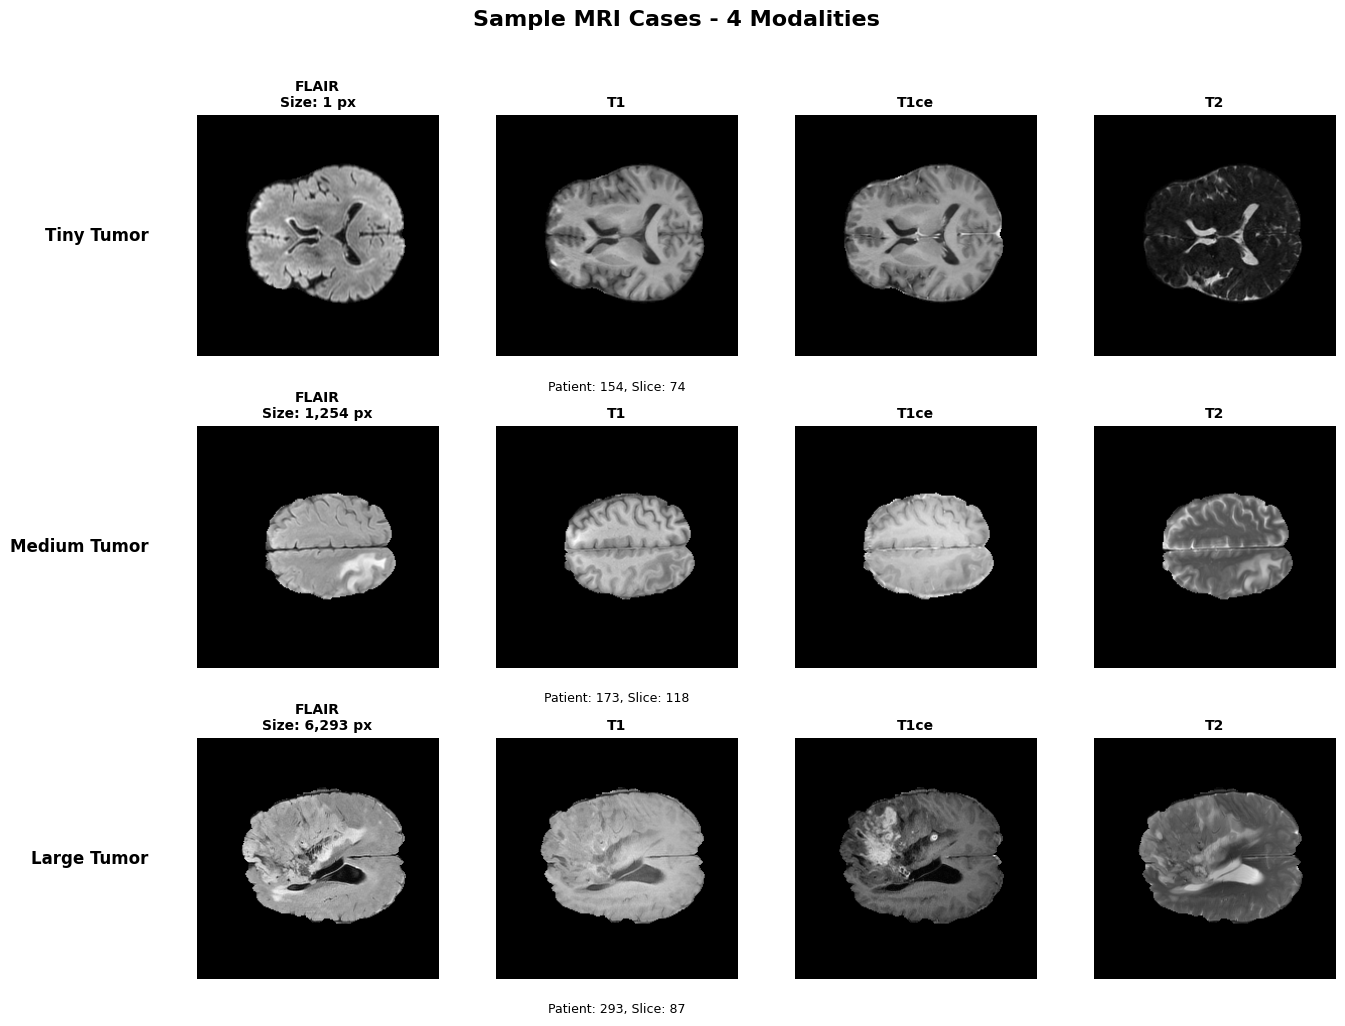

In [74]:
print("Sample Visualizations")

# find examples of different tumor sizes 
tiny_tumor_idx = np.argmin(tumor_sizes)  
medium_tumor_idx = np.argsort(tumor_sizes)[len(tumor_sizes)//2]  
large_tumor_idx = np.argmax(tumor_sizes)  
    
# get the corresponding rows from tumor_sample
tiny_sample = tumor_sample.iloc[tiny_tumor_idx]
medium_sample = tumor_sample.iloc[medium_tumor_idx]
large_sample = tumor_sample.iloc[large_tumor_idx]
    
samples = [
    ('Tiny Tumor', tiny_sample, tumor_sizes[tiny_tumor_idx]),
    ('Medium Tumor', medium_sample, tumor_sizes[medium_tumor_idx]),
    ('Large Tumor', large_sample, tumor_sizes[large_tumor_idx])
    ]
    
# create visualization
fig, axes = plt.subplots(3, 4, figsize=(14, 10)) 

for row, (title, sample_row, tumor_size) in enumerate(samples):
    try:
        # load file
        slice_path = sample_row['slice_path']
        
        if not Path(slice_path).exists():
            slice_name = slice_path.split('/')[-1]
            h5_files = list(data_path.rglob(slice_name))
            if h5_files:
                slice_path = h5_files[0]
        
        with h5py.File(slice_path, 'r') as f:
            image = f['image'][:]  
            mask = f['mask'][:] 
        
        tumor_px = np.sum(mask > 0)
        print(f"{title}: Tumor pixels = {tumor_px}")
        
        # display each MRI channel
        channel_names = ['FLAIR', 'T1', 'T1ce', 'T2']
        for col in range(4):
            ax = axes[row, col]
            ax.imshow(image[:, :, col], cmap='gray')
            
            # add tumor info to title
            title_text = channel_names[col]
            if col == 0: 
                if tumor_size is not None:
                    title_text = f'{channel_names[col]}\nSize: {tumor_size:,} px'
                else:
                    title_text = f'{channel_names[col]}\nTumor: {tumor_px} px'
            
            ax.set_title(title_text, fontsize=10, fontweight='bold')
            ax.axis('off')
        
        # add row label
        axes[row, 0].text(-0.2, 0.5, title, transform=axes[row, 0].transAxes,
                         fontsize=12, fontweight='bold', va='center', ha='right')
        
        # add patient/slice info
        info_text = f"Patient: {int(sample_row['volume'])}, Slice: {int(sample_row['slice'])}"
        axes[row, 1].text(0.5, -0.1, info_text, transform=axes[row, 1].transAxes,
                         fontsize=9, ha='center', va='top')
        
    except Exception as e:
        print(f"Error loading sample: {e}")
        for col in range(4):
            axes[row, col].clear()
            axes[row, col].text(0.5, 0.5, f'Error\n{str(e)[:50]}...', 
                              ha='center', va='center', fontsize=8)
            axes[row, col].axis('off')

plt.suptitle('Sample MRI Cases - 4 Modalities', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(output_dir / 'sample_mri_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

**Visualization Findings:**
- Tiny tumor is invisible to the naked eye.
    - Requires pixel-level detection.
- Medium tumor is subtle but visible.
- Large tumor is obvious and extensive
    - Easy to detect, but has complex boundaries.


## Conclusion

### **Dataset Overview**
- **57,195 MRI slices** from **369 glioma patients**
- **4 MRI modalities** per slice (FLAIR, T1, T1ce, T2)
- **Standard format**: All slices 240×240 pixels, 155 slices/patient

### **Class Distribution**
- **43% tumor slices** (24,369) vs **57% healthy slices** (32,826)
- **Moderate balance**: 1.3:1 healthy:tumor ratio

### **Tumor Characteristics**
- **Size range**: 1 to 6,293 pixels
- **Average**: 1,488 pixels (median: 1,253)
- **72% small-to-medium** (<2,000 pixels)
- **Only necrosis** tissue present

### **Spatial Patterns**
- **Middle region hotspot**: 81% tumor probability (slices 52-103)
- **26 slices** have no tumors

### **Visualization Findings**
- **Tiny tumor** is invisible to the naked eye
    - Requires pixel-level detection
- **Medium tumor** is subtle but visible
- **Large tumor** is obvious and extensive
    - Easy to detect, but has complex boundaries

### **Modeling Recommendations**
- **U-Net** with **4-channel input**
- **Attention mechanisms** for small tumors
- **Mild class weighting** (1.3:1)
- **Patient-wise** data splitting